In [ ]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import imageio
import glob

from skimage import io
import cv2 as cv 
from google.colab.patches import cv2_imshow

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def load_warwick(folder_path):

  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  for image_path in sorted(glob.glob(str(folder_path) + "/Train/image_*.png")):
    image = imageio.imread(image_path)
    train_images.append(image)
  for label_path in sorted(glob.glob(str(folder_path) + "/Train/label_*.png")):
    label = imageio.imread(label_path)
    train_labels.append(label)  

  for image_path in sorted(glob.glob(str(folder_path) + "/Test/image_*.png")):
    image = imageio.imread(image_path)
    test_images.append(image)
  for label_path in sorted(glob.glob(str(folder_path) + "/Test/label_*.png")):
    label = imageio.imread(label_path)
    test_labels.append(label)

  X_train = torch.tensor(np.array(train_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_train = torch.tensor(np.array(train_labels)/255.0, dtype=torch.long)
  X_test = torch.tensor(np.array(test_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_test = torch.tensor(np.array(test_labels)/255.0, dtype=torch.long)

  return X_train, Y_train, X_test, Y_test

In [ ]:
class semanticSegmentation_cnn(nn.Module):
  def __init__(self):
    super(semanticSegmentation_cnn, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.convTranspose1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
    self.convTranspose2 = nn.ConvTranspose2d(in_channels=16+16, out_channels=8, kernel_size=4, stride=2, padding=1)
    self.conv1x1_out = nn.Conv2d(in_channels=8+8, out_channels=2, kernel_size=1, stride=1, bias=True)

  def forward(self, x):
    l1 = F.relu(self.conv1(x))
    l2 = self.maxpool(l1)
    l3 = F.relu(self.conv2(l2))
    l4 = self.maxpool(l3)
    l5 = F.relu(self.conv3(l4))
    l6 = F.relu(self.convTranspose1(l5))
    l7 = F.relu(self.convTranspose2(torch.cat((l3,l6),dim=1)))
    return self.conv1x1_out(torch.cat((l1,l7),dim=1))

In [ ]:
def accuracy(predictions, Y, coefficient=False):
  predictions = torch.max(predictions, 1)[1]
  return dice_loss(predictions, Y, coefficient)

In [ ]:
def dice_loss(predictions, Y, coefficient=False,smooth=1):
  batch_size = predictions.size(0)
  predictions_flat = predictions.view(batch_size, -1)
  Y_flat = Y.view(batch_size, -1)
  intersection = (predictions_flat * Y_flat).sum(1)
  unionset = predictions_flat.sum(1) + Y_flat.sum(1)
  coef = 2 * (intersection + smooth) / (unionset + smooth)
  if coefficient == False:
    return coef.sum() / batch_size
  else:
    return coef

In [ ]:
def plot_cost_iteration(training_loss, test_loss, iterations):
  plt.plot(np.arange(start=0, stop=iterations, step= 1), training_loss, label='Training data')
  plt.plot(np.arange(start=0, stop=iterations, step= 1), test_loss, label='Test data')
  plt.xlabel('Iteration')
  plt.ylabel('Cost')
  plt.title('Cost per Iteration')
  plt.legend()
  plt.show()

In [ ]:
def plot_accuracy_iteration(training_accuracy, test_accuracy, iterations):
  plt.plot(np.arange(start=1, stop=iterations+1, step= 1), training_accuracy, label='Training data')
  plt.plot(np.arange(start=1, stop=iterations+1, step= 1), test_accuracy, label='Test data')
  plt.xlabel('Iteration')
  plt.ylabel('Accuracy')
  plt.title('Accuracy per Iteration')
  plt.legend()
  plt.show()

In [ ]:
warwick_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning for Image Analysis/warwick_dataset'
X_train, Y_train, X_test, Y_test = load_warwick(warwick_path)

training_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

Epoch     5: train loss  9.19 train accuracy   2.05 test loss  7.17 test accuracy   5.28
Epoch    10: train loss  3.94 train accuracy  30.08 test loss  2.96 test accuracy  47.65
Epoch    15: train loss  3.68 train accuracy  60.84 test loss  3.67 test accuracy  60.93
Epoch    20: train loss  2.44 train accuracy  55.28 test loss  2.27 test accuracy  55.23
Epoch    25: train loss  2.12 train accuracy  48.07 test loss  1.91 test accuracy  49.86
Epoch    30: train loss  1.89 train accuracy  49.36 test loss  1.74 test accuracy  51.63
Epoch    35: train loss  1.68 train accuracy  54.49 test loss  1.65 test accuracy  55.17
Epoch    40: train loss  1.57 train accuracy  57.18 test loss  1.61 test accuracy  56.58
Epoch    45: train loss  1.45 train accuracy  57.38 test loss  1.48 test accuracy  56.06
Epoch    50: train loss  1.34 train accuracy  55.66 test loss  1.35 test accuracy  53.89
Epoch    55: train loss  1.27 train accuracy  54.48 test loss  1.28 test accuracy  53.30
Epoch    60: train lo

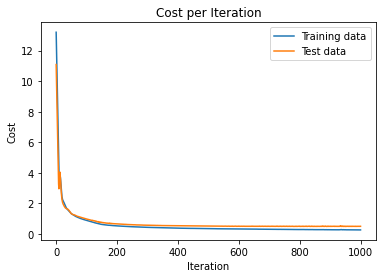

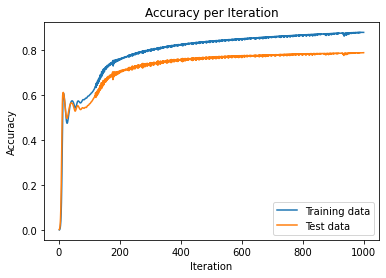

In [ ]:
# Initialise hyperparameters
minibatch_size = 85
learning_rate = 0.001
iterations = 1000

# Data structures to hold accuracy and loss values throughout the iterations
training_accuracy = []
training_loss = []
test_accuracy = []
test_loss = []

# Load the training and test dataset without shuffling
train_dataLoader = torch.utils.data.DataLoader(training_dataset, batch_size=minibatch_size, shuffle=False)
test_dataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Create the network
segmentation_cnn = semanticSegmentation_cnn()
segmentation_cnn.to(device)

# Use Stochastic Gradient Descent optimiser
optimiser = optim.Adam(segmentation_cnn.parameters(), lr=learning_rate)
loss_funtion = nn.CrossEntropyLoss()

# Training
for epoch in range(0, iterations):
    epoch_loss = 0
    epoch_accuracy = 0
    for (x_batch, y_batch) in train_dataLoader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimiser.zero_grad()
      predictions = segmentation_cnn(x_batch) # Forward pass on training batch
      batch_accuracy = accuracy(predictions, y_batch) # Compute accuracy on training batch
      epoch_accuracy += batch_accuracy.item()
      loss = loss_funtion(torch.squeeze(predictions), y_batch) # Compute loss on training batch
      batch_loss = loss.item()
      epoch_loss += batch_loss
      loss.backward() # Back propagation
      optimiser.step() # Parameters update

    training_accuracy.append(epoch_accuracy / len(train_dataLoader))
    training_loss.append(epoch_loss / len(train_dataLoader))

    with torch.no_grad():
      for (x_test, y_test) in test_dataLoader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        predictions = segmentation_cnn(x_test) # Forward pass on test dataset
        test_accuracy.append(accuracy(predictions, y_test).item()) # Compute accuracy on test dataset
        test_loss.append(loss_funtion(torch.squeeze(predictions), y_test).item()) # Compute loss on test dataset
    
    if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch+1:5d}: train loss {training_loss[-1]:5.2f} train accuracy {100*training_accuracy[-1]:6.2f} '\
            f'test loss {test_loss[-1]:5.2f} test accuracy {100*test_accuracy[-1]:6.2f}')

# Plotting
plot_cost_iteration(training_loss, test_loss, iterations)
plot_accuracy_iteration(training_accuracy, test_accuracy, iterations)

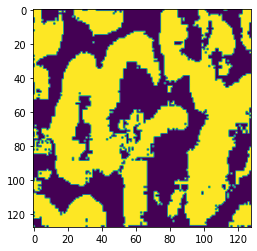

In [ ]:
image_index = 8
image_pred = predictions[image_index].cpu()
image_pred = torch.max(image_pred, 0)[1]
plt.imshow(image_pred, interpolation='bilinear')

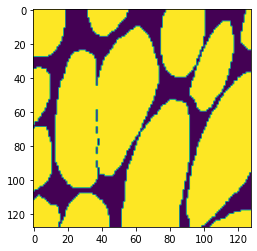

In [ ]:
image_label = y_test[image_index].cpu().numpy()
plt.imshow(image_label, interpolation='bilinear')